In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ifd_arr87 = './Assignment_2__Input_FE/inputs_2025_Autumn_PRM/ARR87_IFDs.csv'
catch_area = 2.4

C10_min_contour = 0.6
C10_max_contour = 0.8
C10_mean_contour = 0.7

num_simulations = 1_000_000

print(
    ifd_arr87,
    catch_area,
    C10_min_contour,
    C10_max_contour,
    C10_mean_contour,
    sep='\n')

./Assignment_2__Input_FE/inputs_2025_Autumn_PRM/ARR87_IFDs.csv
2.4
0.6
0.8
0.7


In [3]:
df_ifd = pd.read_csv(filepath_or_buffer=ifd_arr87, skiprows=2)
df_ifd['duration'] = df_ifd.DURATION.str.split(pat=' ').str[0].astype(int)
df_ifd['units'] = df_ifd.DURATION.str.split(pat=' ').str[1]
df_ifd.units = df_ifd.units.map(arg={'mins':'min', 'hours':'hr', 'hour':'hr'})
df_ifd.duration = df_ifd.apply(func=lambda arg: pd.to_timedelta(arg=arg.duration, unit=arg.units), axis=1)
df_ifd.duration = df_ifd.duration / pd.Timedelta(minutes=1)
df_ifd['duration'] = df_ifd['duration'].astype(int)
df_ifd.drop(columns=['DURATION', 'units'], inplace=True)
df_ifd.set_index(keys='duration', inplace=True)
df_ifd.columns = df_ifd.columns.astype(int)

df_ifd

,1,2,5,10,20,50,100
duration,,,,,,,
5,92.20,118.00,150.00,168.00,192.00,224.00,248.00
6,86.40,111.00,141.00,158.00,181.00,210.00,233.00
10,70.70,90.70,116.00,130.00,149.00,174.00,193.00
20,51.70,66.50,85.60,96.70,111.00,130.00,145.00
30,42.10,54.20,70.10,79.30,91.40,107.00,119.00
60,28.50,36.80,47.90,54.40,62.90,74.10,82.60
120,18.60,24.10,31.50,35.80,41.50,49.00,54.70
180,14.40,18.60,24.40,27.70,32.20,38.00,42.40
360,9.18,11.90,15.60,17.80,20.70,24.50,27.40


In [4]:
tc = 0.76*(catch_area**0.38)
tc = tc*60

tc

63.59824252533506

In [5]:
# Find the insertion point
idx = np.searchsorted(df_ifd.index.to_numpy(), tc)

# Determine the limits
if idx == 0:
    lower_limit = None
    upper_limit = df_ifd.index.to_numpy()[0]
elif idx == len(df_ifd.index.to_numpy()):
    lower_limit = df_ifd.index.to_numpy()[-1]
    upper_limit = None
else:
    lower_limit = df_ifd.index.to_numpy()[idx - 1]
    upper_limit = df_ifd.index.to_numpy()[idx]

idx = np.array(object=[lower_limit, upper_limit])
idx

array([ 60, 120])

In [6]:
I_minh_Xy = df_ifd.loc[idx.min(),:].to_numpy()
I_maxh_Xy = df_ifd.loc[idx.max(),:].to_numpy()

I_minh_Xy, I_maxh_Xy

(array([28.5, 36.8, 47.9, 54.4, 62.9, 74.1, 82.6]),
 array([18.6, 24.1, 31.5, 35.8, 41.5, 49. , 54.7]))

In [7]:
# I_1h_100y = df_ifd.loc[60,100]
# I_2h_100y = df_ifd.loc[120,100]

# I_1h_100y, I_2h_100y

In [8]:
I_catch = [np.interp(x=tc, xp=[60,120], fp=[ind1, ind2]) for ind1,ind2 in zip(I_minh_Xy, I_maxh_Xy)]
I_catch = np.array(object=I_catch)

I_catch

array([27.90628998, 36.038372  , 46.91648038, 53.28454482, 61.61662683,
       72.59473521, 80.92681723])

In [9]:
# I_catch = np.interp(x=tc, xp=[60,120], fp=[I_1h_100y,I_2h_100y])

# I_catch

In [10]:
# Mean and standard deviation
contours = np.array(object=[C10_min_contour, C10_max_contour])
six_sigma = 2*np.min(a=abs(contours - C10_mean_contour))
std_dev = six_sigma / 6
contours = np.array(object=[C10_mean_contour - 3*std_dev, C10_mean_contour + 3*std_dev])

# Generate random points with a normal distribution
C10_value = np.random.normal(C10_mean_contour, std_dev, num_simulations)

# Filter points to be within the desired range (0.7 to 0.8)
C10_value = C10_value[(C10_value >= contours.min()) & (C10_value <= contours.max())]
C10_value = np.sort(a=C10_value)

C10_value

array([0.60000048, 0.60000552, 0.60000811, ..., 0.79997083, 0.79997267,
       0.79999266])

In [11]:
I_12h_50y = df_ifd.loc[720,50]
I_12h_2y = df_ifd.loc[720,2]

I_12h_50y, I_12h_2y

(15.9, 7.69)

In [12]:
FF_50 = 1.99 - 0.366*I_12h_50y/I_12h_2y
FF_100 = 2.57 - 0.588*I_12h_50y/I_12h_2y

FF_50, FF_100

(1.233250975292588, 1.3542392717815344)

In [13]:
FF_y = {
    'FF_1': 0.62, 
    'FF_2': 0.74, 
    'FF_5': 0.88, 
    'FF_10': 1, 
    'FF_20': 1.12,
    'FF_50': FF_50,
    'FF_100': FF_100,
    }

FF_y

{'FF_1': 0.62,
 'FF_2': 0.74,
 'FF_5': 0.88,
 'FF_10': 1,
 'FF_20': 1.12,
 'FF_50': 1.233250975292588,
 'FF_100': 1.3542392717815344}

In [14]:
np.array(object=list(FF_y.values()))

array([0.62      , 0.74      , 0.88      , 1.        , 1.12      ,
       1.23325098, 1.35423927])

In [15]:
C100 = np.array(object=[C10_value*ind for ind in np.array(object=list(FF_y.values()))])

C100

array([[0.3720003 , 0.37200342, 0.37200503, ..., 0.49598191, 0.49598306,
        0.49599545],
       [0.44400036, 0.44400408, 0.444006  , ..., 0.59197841, 0.59197978,
        0.59199457],
       [0.52800043, 0.52800486, 0.52800713, ..., 0.70397433, 0.70397595,
        0.70399354],
       ...,
       [0.67200054, 0.67200618, 0.67200908, ..., 0.89596733, 0.89596939,
        0.89599178],
       [0.73995118, 0.73995739, 0.73996058, ..., 0.9865648 , 0.98656708,
        0.98659172],
       [0.81254422, 0.81255104, 0.81255454, ..., 1.08335191, 1.08335441,
        1.08338147]])

In [16]:
# C100 = FF_100 * C10_value
# C100

In [17]:
Q_y = C100*np.reshape(a=I_catch, newshape=(7,1))*catch_area/3.6
Q_y = np.transpose(a=Q_y)
Q_y = pd.DataFrame(data=Q_y, columns=df_ifd.columns)

Q_y

,1,2,5,10,20,50,100
0,6.920766,10.667367,16.514614,21.313835,27.604271,35.811040,43.837745
1,6.920824,10.667456,16.514753,21.314014,27.604503,35.811341,43.838113
2,6.920853,10.667502,16.514824,21.314106,27.604622,35.811495,43.838302
3,6.920933,10.667625,16.515014,21.314351,27.604939,35.811907,43.838806
4,6.920936,10.667629,16.515021,21.314360,27.604951,35.811922,43.838825
...,...,...,...,...,...,...,...
997309,9.227208,14.222416,22.018341,28.416969,36.803781,47.745571,58.447287
997310,9.227239,14.222465,22.018417,28.417067,36.803907,47.745735,58.447488
997311,9.227343,14.222625,22.018665,28.417388,36.804323,47.746274,58.448148
997312,9.227365,14.222658,22.018716,28.417453,36.804408,47.746384,58.448283


In [18]:
Q_y_stats = Q_y.describe(percentiles=[0.05, 0.5, 0.95])

Q_y_stats

,1,2,5,10,20,50,100
count,997314.000000,997314.000000,997314.000000,997314.000000,997314.000000,997314.000000,997314.000000
mean,8.074512,12.445702,19.267733,24.867022,32.206124,41.781027,51.145848
std,0.379126,0.584369,0.904687,1.167593,1.512189,1.961764,2.401475
min,6.920766,10.667367,16.514614,21.313835,27.604271,35.811040,43.837745
5%,7.447435,11.479152,17.771375,22.935816,29.704953,38.536256,47.173792
50%,8.074520,12.445713,19.267750,24.867045,32.206153,41.781065,51.145894
95%,8.701799,13.412573,20.764588,26.798871,34.708127,45.026877,55.119224
max,9.227595,14.223014,22.019266,28.418163,36.805327,47.747577,58.449743


In [19]:
print(Q_y_stats.index)

Index(['count', 'mean', 'std', 'min', '5%', '50%', '95%', 'max'], dtype='object')


In [20]:
Q_y_plot = Q_y_stats.copy()
Q_y_plot.drop(index=['count', 'std'], inplace=True)

Q_y_plot

,1,2,5,10,20,50,100
mean,8.074512,12.445702,19.267733,24.867022,32.206124,41.781027,51.145848
min,6.920766,10.667367,16.514614,21.313835,27.604271,35.811040,43.837745
5%,7.447435,11.479152,17.771375,22.935816,29.704953,38.536256,47.173792
50%,8.074520,12.445713,19.267750,24.867045,32.206153,41.781065,51.145894
95%,8.701799,13.412573,20.764588,26.798871,34.708127,45.026877,55.119224
max,9.227595,14.223014,22.019266,28.418163,36.805327,47.747577,58.449743


In [21]:
x = Q_y_stats.columns.to_numpy()
y_mean = Q_y_stats.loc['mean'].to_numpy()
y_05 = Q_y_stats.loc['5%'].to_numpy()
y_50 = Q_y_stats.loc['50%'].to_numpy()
y_95 = Q_y_stats.loc['95%'].to_numpy()
y_min = Q_y_stats.loc['min'].to_numpy()
y_max = Q_y_stats.loc['max'].to_numpy()

x

array([  1,   2,   5,  10,  20,  50, 100])

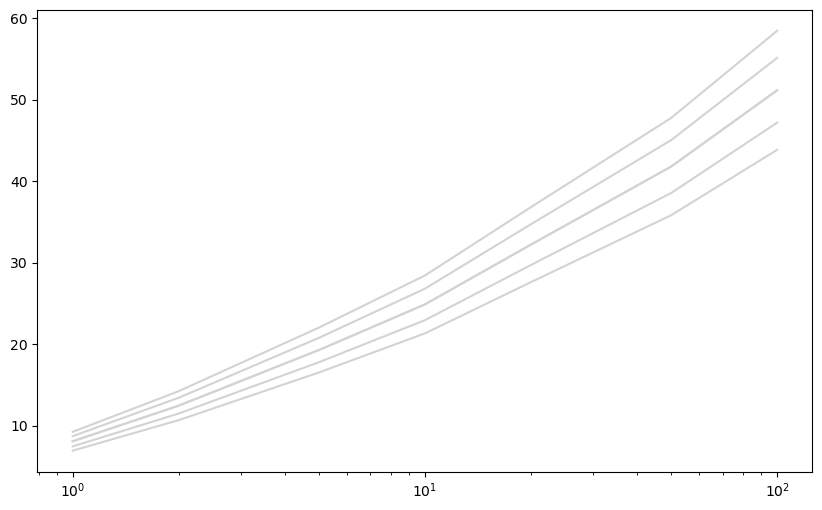

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(Q_y_plot.T, color='lightgrey', alpha=1)
ax.set_xscale('log')